In [2]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-10-29 17:11:48.955069: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 17:11:48.957107: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 17:11:48.981990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 17:11:48.982021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 17:11:48.982982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [3]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 17)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9
602645,R80736,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1
602646,R80736,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1
602647,R80711,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0
602648,R80736,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0


In [4]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [5]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9
602645,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1
602646,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1
602647,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0
602648,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0


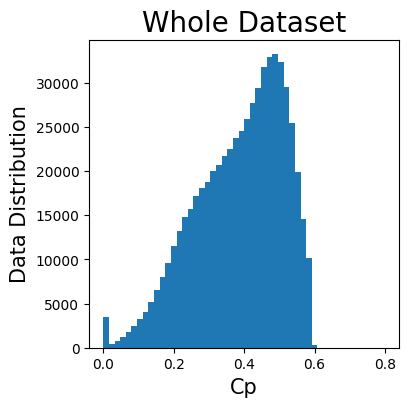

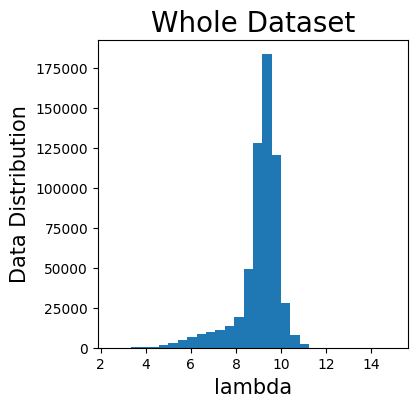

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9,0.079908,3.707248
602645,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1,0.078364,3.676787
602646,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1,0.073819,3.607639
602647,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0,0.073492,3.605878
602648,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0,0.073318,3.598171


In [6]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [7]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.08,-1.000000,-0.990000,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.05,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,-28.785794,111.742447,-180.00,-130.160000,-59.269990,55.330002,1.799900e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.49,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.00,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.00,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.23,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,-28.404289,112.121101,-180.00,-130.640000,-57.989990,56.000000,1.799900e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.34,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.95,5.960000,10.910000,16.330000,3.828000e+01


In [8]:
# Normalization 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
dataset_norm = dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_norm[col]=(dataset[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_norm[col]=dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -0.081045       5.978549
hub_temperature          19.060174       5.838598
nacelle_angle           -28.785794     111.742447
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              -28.404289     112.121101
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            -29.302312     111.841797
nacelle_angle_c         -29.710568     111.627225
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435
lambda                    9.004813       1.167138

Normalized dataset
                             m

In [9]:
# load existing Cp model
Cp_model = tf.keras.models.load_model('../Models/Cp2D_sigmoid.h5')
Cp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               384       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17025 (66.50 KB)
Trainable params: 17025 (66.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-29 17:12:07.003577: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
print('V_mean',x_mean[6])
print('V_std',x_std[6])

print('W_mean',x_mean[10])
print('W_std',x_std[10])

print('lambda_mean',x_mean[17])
print('lambda_std',x_std[17])

V_mean 6.314169410268349
V_std 1.9826865496833004
W_mean 1.3624695745853583
W_std 0.31885227928881654
lambda_mean 9.00481267746856
lambda_std 1.1671372926258912


In [40]:
# Define P_phys model from the previous Cp model

from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate

# Mean and standard deviation for normalization
V_mean = 6.314169410268349
V_std = 1.9826865496833004
W_mean = 1.3624695745853583
W_std = 0.31885227928881654
l_mean = 9.00481267746856
l_std = 1.167137292625891

# Print the shape of the Cp_model input
print(Cp_model.input_shape)

# Define a single input with shape (3,)
input_tensor = Input(shape=(3,), name='xphys')

# Slice the input tensor into three components: V, theta, and W
V = Lambda(lambda x: x[:, 0:1])(input_tensor)  # Slice for V (first element)
theta = Lambda(lambda x: x[:, 1:2])(input_tensor)  # Slice for theta (second element)
W = Lambda(lambda x: x[:, 2:3])(input_tensor)  # Slice for W (third element)

# Convert V and W from normalized units to original units to comput lambda
V_aux = V * V_std + V_mean
W_aux = W * W_std + W_mean
l_aux = W_aux * const.R / V_aux
lambd = (l_aux - l_mean)/l_std

# Concatenate lambd and theta into a single input tensor for Cp_model
input_Cp = Concatenate()([lambd,theta]) # This creates a new tensor with shape (None, 2)

# Pass the input to the Cp model
Cp_output = Cp_model(input_Cp) 

# Define the function for P(V, theta, W) = 0.5 * rho * Cp(V, theta, W) * A * V^3
def power_function(inputs):
    V_val = inputs[0]  # Extract V (velocity)
    Cp_val = inputs[1]  # Extract Cp output from the model

    # Convert V and Cp to original units
    Cp_val = Cp_val * Cp_max
    V_val = V_val * V_std + V_mean

    return 0.5 * const.rho * const.A * Cp_val * K.pow(V_val, 3)

# Apply the custom power function
P_output = Lambda(power_function)([V, Cp_output])

# Create the new model for P(V, theta, W)
Pphys_model = tf.keras.models.Model(inputs=input_tensor, outputs=P_output)

# Compile the new model if you plan to train it further
Pphys_model.compile(optimizer='adam', loss='mse')

# Model summary (optional)
Pphys_model.summary()

(None, 2)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xphys (InputLayer)          [(None, 3)]                  0         []                            
                                                                                                  
 lambda_17 (Lambda)          (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 lambda_15 (Lambda)          (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 tf.math.multiply_13 (TFOpL  (None, 1)                    0         ['lambda_17[0][0]']           
 ambda)                                                                           

In [ ]:
Pphys_model.save('../Models/Pphys_Cp2D.h5')

In [13]:
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys_Cp2D.h5')

In [14]:
# Define input features to define P_phys
dataset_copy = dataset_norm.copy()
xphys = dataset_copy[['V','theta','W']]

# Evaluate power in normalized units
P_phys = Pphys_model.predict(xphys).flatten()

18833/18833 [==============================] - 8s 440us/step


In [15]:
# Add physical and residual power to the dataset
dataset['P_phys'] = P_phys
dataset.describe().transpose()
#dataset['P_res'] = dataset['P_phys'] - dataset['P']
dataset['P_res'] = dataset['P'] - dataset['P_phys']
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.08,-1.000000,-0.990000,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.05,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,-28.785794,111.742447,-180.00,-130.160000,-59.269990,55.330002,1.799900e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.49,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.00,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.00,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.23,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,-28.404289,112.121101,-180.00,-130.640000,-57.989990,56.000000,1.799900e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.34,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.95,5.960000,10.910000,16.330000,3.828000e+01


In [16]:
# Split the data into training and test sets

train_dataset_norm = dataset_norm.sample(frac=0.8, random_state=10)
test_dataset_norm = dataset_norm.drop(train_dataset_norm.index)
train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

# Split input features from labels/targets

test_features = test_dataset_norm[['V','theta','W']]
test_labels = test_dataset.pop('P')

print(test_features.shape)
print(test_labels.shape)

(120530, 3)
(120530,)


3767/3767 [==============================] - 2s 448us/step


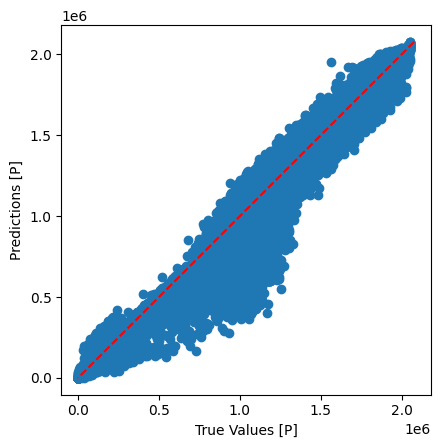


Test MAE: 47284.253765302594
Test RMSE: 96390.54421000491
Test MAPE: 12.16857592988345 %
Test R2: 0.9537152832132731


In [46]:
# Evaluate Pphys from Cp

def P_fromCp(Cp, Vw):
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    return Pturbina

P_pred = Pphys_model.predict(test_features[['V','theta','W']]).flatten()
P_true = test_labels
y_true = P_true
y_pred = P_pred

# Plot
a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

# Metrics
p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

3767/3767 [==============================] - 2s 455us/step
(120530,)
(120530,)


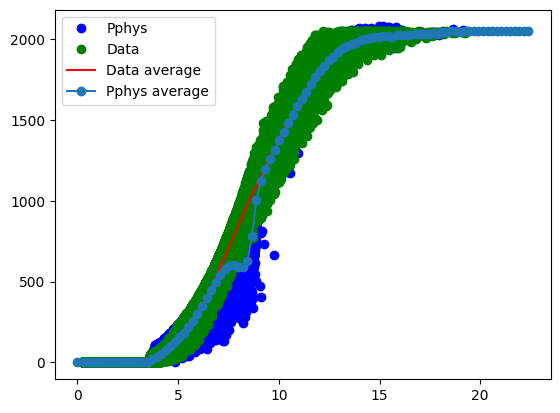

In [29]:
# Plot Pphys vs V and scatter data

P_pred = Pphys_model.predict(test_features[['V','theta','W']]).flatten()
P_true = test_labels
print(P_pred.shape)
print(P_true.shape)

V_mean = 6.314169410268349
V_std = 1.9826865496833004
V_data = test_features['V']*V_std + V_mean

# Estimate the power curve with an iterative median estimation technique. 
vmin = 0
vmax = 22.5
nbins = 100
P_estimated = np.zeros(nbins)
V_estimated = np.zeros(nbins)
Pphys_estimated = np.zeros(nbins)
dv = (vmax-vmin)/nbins

P_estimated[0]=0.0
Pphys_estimated[0]=0.0
for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv

    # Median of P in the bin i
    V_estimated[i] = (vl+vr)/2.0
    v_subset = (vl<V_data) & (V_data<vr)  # subset of v points of the bin
    Pi = P_true[v_subset]                      # Power distribution of bin i
    Pphys_i = P_pred[v_subset]                      
    if (len(Pi)>0):
        P_estimated[i]=statistics.mean(Pi)
        Pphys_estimated[i]=statistics.mean(Pphys_i)
    else:
        P_estimated[i]=P_estimated[i-1]
        Pphys_estimated[i]=Pphys_estimated[i-1]

    if(V_estimated[i]>=15 and P_estimated[i]-P_estimated[i-1]<0):
        P_estimated[i] = P_estimated[i-1]

plt.plot(V_data, P_pred/1000,'bo',label='Pphys')
plt.plot(V_data, P_true/1000,'go',label='Data')
plt.plot(V_estimated,P_estimated/1000,'r-',label='Data average')
plt.plot(V_estimated,Pphys_estimated/1000,'o-',label='Pphys average')
plt.legend()